## Loading up packages

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Load up the necessary packages 
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from plastid.plotting.plots import *
from scipy import stats
from scipy.stats import kstwo
from statsmodels.stats.proportion import proportions_ztest
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy
import seaborn as sns

In [3]:
# Define the path to our data files and the path we want to save our outputs in. 
target_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/Selenoprotein_table.csv'
ks_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/villar/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'
samp_num = '2'

## Defining functions

In [4]:
def split_equal(value, parts):
    value = float(value)
    return [i*value/parts for i in range(1,parts+1)]

In [5]:
def determine_enrichment(targ_ks, all_ks, N_cats, max_ks):
    ratios = []
    sections = split_equal(max_ks, N_cats)
    ratios.append(len(targ_ks.ks_stat[targ_ks.ks_stat < sections[0]])/len(all_ks.ks_stat[all_ks.ks_stat < sections[0]]))
    for sec, i in zip(sections, list(range(len(sections)))):
        try:
            ratios.append(len(targ_ks.ks_stat[(targ_ks.ks_stat > sec) & (targ_ks.ks_stat < sections[i+1])]
                )/len(all_ks.ks_stat[(all_ks.ks_stat > sec) & (all_ks.ks_stat < sections[i+1])]))
        except:
            pass
    ratios.append(len(targ_ks.ks_stat[targ_ks.ks_stat > sections[-1]])/len(all_ks.ks_stat[all_ks.ks_stat > sections[-1]]))
    return ratios, sections

In [6]:
def det_p_values(targ_ks, all_ks, sections):
    p_values = []
    for sec, i in zip(sections, list(range(len(sections)))):
        try:
            obs = len(targ_ks.ks_stat[(targ_ks.ks_stat > sec) & (targ_ks.ks_stat < sections[i + 1])])
            all_p = len(all_ks.ks_stat[(all_ks.ks_stat > sec) & (all_ks.ks_stat < sections[i + 1])])
            p_v = proportions_ztest(obs, all_p, len(targ_ks)/len(all_ks))[1]
            p_values.append(p_v)
        except:
            pass
    obs = len(targ_ks.ks_stat[targ_ks.ks_stat > sections[-1]])
    all_p = len(all_ks.ks_stat[all_ks.ks_stat > sections[-1]])
    p_v = proportions_ztest(obs, all_p, len(targ_ks)/len(all_ks))[1]
    p_values.append(p_v)
    return p_values

## Calculate the KS stat of all of the seleno targets in the Mouse data

In [7]:
# Load up the target gene names. 
seleno_table = pd.read_csv(target_path , names = ["gene_name"])

# Load up the tables of KS statistics
df = pd.read_csv(ks_path + "ks_table_" + samp_num + ".csv")

In [8]:
# Merge the ecoli ks table with the list of gene names
seleno_ks_table = pd.merge(df, seleno_table, how='inner', right_on='gene_name', left_on='gene_ID')

In [9]:
# Keep only one copy of each gene in the seleno table. 
seleno_ks_table.sort_values("gene_name", inplace = True)
seleno_ks_table.drop_duplicates(subset ="gene_name",keep = "first", inplace = True) 

(0.0, 0.7)

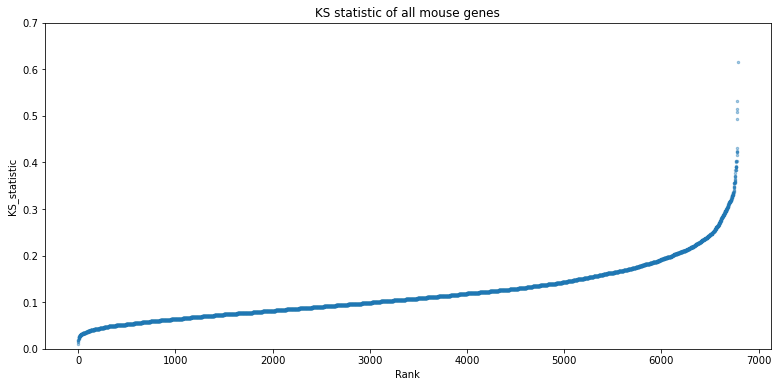

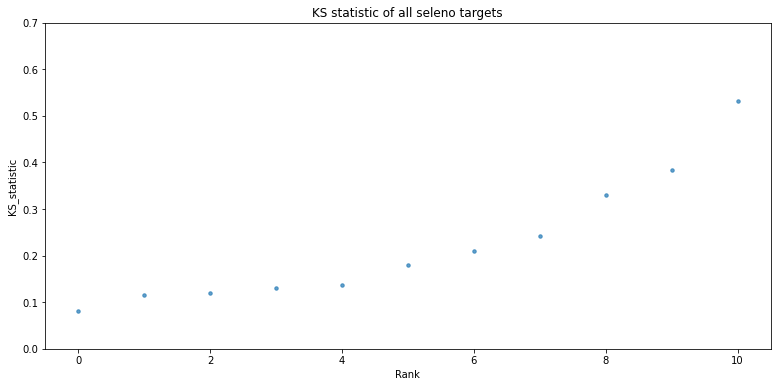

In [13]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (13,6))
plt.scatter(list(range(len(df["ks_stat"]))), sorted(df["ks_stat"]), s=6, alpha = 0.4)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all mouse genes")
plt.ylim(0,0.7)
plt.show
figure(figsize = (13,6))
plt.scatter(list(range(len(seleno_ks_table["ks_stat"]))), sorted(seleno_ks_table["ks_stat"]), s=12, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all seleno targets")
plt.ylim(0,0.7)

In [14]:
# print out the mean of all polyprolne motif containing genes (efp targets)
print("mean KS statistic of seleno target genes = " + str(np.mean(seleno_ks_table.ks_stat)))
print("mean KS statistic of all D.mel genes = " + str(np.mean(df.ks_stat)))

mean KS statistic of seleno target genes = 0.22345454108358928
mean KS statistic of all D.mel genes = 0.11924525876503049


In [15]:
max_ks = 0.3
N_cats = 2
ratios, sections = determine_enrichment(seleno_ks_table, df, N_cats, max_ks)

In [16]:
sections.insert(0,0)

In [17]:
det_p_values(seleno_ks_table, df, sections)

[0.12778467442278374, 0.7351699862915655, 0.09906021919288205]

In [18]:
len(seleno_ks_table.ks_stat)/len(df.ks_stat)

0.001621701312103789

## Looking at the proportion of the targets in each KS-stat categroy

In [19]:
split_equal(0.15,2)

[0.075, 0.15]

In [72]:
max_ks = 0.15
N_cats = 2
ratios, sections = determine_enrichment(seleno_ks_table, df, N_cats, max_ks)

In [73]:
sections.insert(0,0)

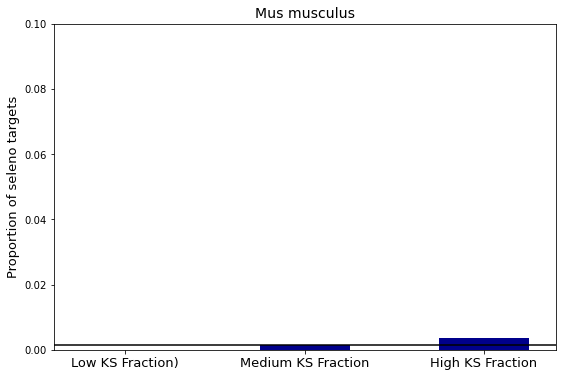

In [74]:
expected = len(seleno_ks_table.ks_stat)/len(df.ks_stat)
figure(figsize = (9,6))
plt.bar([1,2,3],ratios, width = 0.5, color = "darkblue",
        tick_label = ["Low KS Fraction)","Medium KS Fraction","High KS Fraction"])
plt.xticks(fontsize = 13)
plt.xlim(0.6,3.4)
plt.ylim(0, 0.1)
plt.ylabel("Proportion of seleno targets", fontsize = 13)
plt.title("Mus musculus", fontsize = 14)
#plt.xlabel("KS-stat")
plt.plot([0,6],[expected,expected], color = "black")
plt.savefig(save_path + 'mmus_proportions.pdf')

## Looking at the kernel density estimates

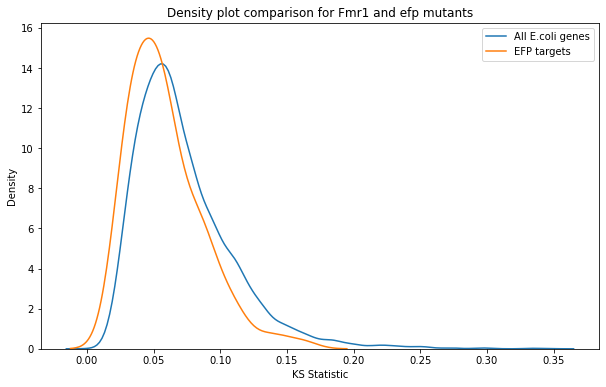

In [27]:
figure(figsize = (10,6))
sns.kdeplot(df.ks_stat, label = "All E.coli genes")
sns.kdeplot(seleno_ks_table.ks_stat, label = "EFP targets")
plt.ylabel("Density")
plt.xlabel("KS Statistic")
plt.title("Density plot comparison for seleno and efp mutants")
plt.legend()